<a href="https://colab.research.google.com/github/Search-Prem/E-Waste-Generation-Classification/blob/main/E_Waste_Generation_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# E-Waste Classification with EfficientNetV2B0

This notebook trains a convolutional neural network (CNN) using the EfficientNetV2B0 architecture to classify images of e-waste into 10 categories. It includes steps for data loading, preprocessing, model building, training, evaluation, and creating a Gradio interface for inference.

## Setup and Imports

This cell installs the necessary libraries and imports them for use in the notebook.
- `tensorflow`: The main deep learning library.
- `scikit-learn`: Used for calculating class weights.
- `matplotlib`: Used for plotting the training history.
- `gradio`: Used to create a web interface for the model.
- `PIL`: Used for image manipulation within the Gradio interface.

In [5]:
# Install required packages
!pip install tensorflow scikit-learn matplotlib gradio

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import EfficientNetV2B0
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import gradio as gr
from PIL import Image

## Model Definition and Compilation

This section defines the CNN model. It uses a pre-trained EfficientNetV2B0 model as the base, adds data augmentation layers, global average pooling, a dense layer, dropout, and a final dense layer for classification. The base model's first 100 layers are frozen during initial training. The model is compiled with the Adam optimizer, sparse categorical crossentropy loss, and accuracy as the metric.

In [6]:
# Enhanced data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.1),
])

# Load pre-trained model
base_model = EfficientNetV2B0(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze first 100 layers
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

# Build model with extra dense layer - Removed data_augmentation here
model = tf.keras.Sequential([
    layers.Input(shape=(128, 128, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),  # New layer added
    layers.Dropout(0.3),                  # Increased dropout
    layers.Dense(10, activation='softmax')
])

# Compile with lower initial learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Unzipping and loading the data for Processing


In [7]:
!unzip /content/E-Waste.zip -d /content/

## Data Loading and Preparation

This section defines the paths to the training, validation, and test datasets and loads them using `tf.keras.utils.image_dataset_from_directory`. It also calculates class weights to handle potential class imbalance in the dataset.

In [8]:
# Set paths to your dataset - Update these paths based on where your data is in Colab
# For example, if your data is in Google Drive, you might use:
# from google.colab import drive
# drive.mount('/content/drive')
# train_path = '/content/drive/My Drive/E waste data/modified-dataset/train'
# test_path = '/content/drive/My Drive/E waste data/modified-dataset/test'
# val_path = '/content/drive/My Drive/E waste data/modified-dataset/val'
# Or if you've uploaded your data directly to the Colab environment:
# train_path = '/content/modified-dataset/train'
# test_path = '/content/modified-dataset/test'
# val_path = '/content/modified-dataset/val'

# Replace the following lines with the correct paths for your Colab environment
# Assuming the zip file extracted to a directory named 'modified-dataset' in /content/
train_path = '/content/modified-dataset/train'
test_path = '/content/modified-dataset/test'
val_path = '/content/modified-dataset/val'


# Load datasets
train_data = tf.keras.utils.image_dataset_from_directory(
    train_path,
    shuffle=True,
    image_size=(128, 128),
    batch_size=32
)

val_data = tf.keras.utils.image_dataset_from_directory(
    val_path,
    shuffle=True,
    image_size=(128, 128),
    batch_size=32
)

test_data = tf.keras.utils.image_dataset_from_directory(
    test_path,
    shuffle=False,
    image_size=(128, 128),
    batch_size=32
)

# Get class names
class_names = train_data.class_names
print("Class names:", class_names)

# Calculate class weights for imbalanced data
y_train = np.concatenate([y.numpy() for _, y in train_data], axis=0)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

# Apply data augmentation to the training dataset
train_data = train_data.map(lambda x, y: (data_augmentation(x, training=True), y))

Found 2400 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Class names: ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']
Class weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0), 4: np.float64(1.0), 5: np.float64(1.0), 6: np.float64(1.0), 7: np.float64(1.0), 8: np.float64(1.0), 9: np.float64(1.0)}


## Model Training

This section defines callbacks for early stopping and learning rate reduction, and then trains the model using the training data and validation data. The class weights are used to address the imbalanced dataset.

In [9]:
# Callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

# Train for more epochs (early stopping will prevent overtraining)
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 94s 313ms/step - accuracy: 0.2026 - loss: 2.2199 - val_accuracy: 0.7000 - val_loss: 1.4903 - learning_rate: 1.0000e-04
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 42s 161ms/step - accuracy: 0.6288 - loss: 1.3856 - val_accuracy: 0.8667 - val_loss: 0.6903 - learning_rate: 1.0000e-04
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 161ms/step - accuracy: 0.8043 - loss: 0.7381 - val_accuracy: 0.8933 - val_loss: 0.4188 - learning_rate: 1.0000e-04
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 161ms/step - accuracy: 0.8523 - loss: 0.4989 - val_accuracy: 0.9133 - val_loss: 0.3111 - learning_rate: 1.0000e-04
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 162ms/step - accuracy: 0.8859 - loss: 0.4203 - val_accuracy: 0.9267 - val_loss: 0.2681 - learning_rate: 1.0000e-04
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 161ms/step - accuracy: 0.8933 - loss: 0.3368 - val_accuracy: 0.9433 - val_loss: 0.2170 - learning_rate: 1.0000e-04
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 163ms/step - acc

## Evaluation and Visualization

This section evaluates the trained model on the test set and prints the test accuracy and loss. It also plots the training and validation accuracy and loss over epochs to visualize the training progress.

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9404 - loss: 0.1779

Test accuracy: 0.9467, Test loss: 0.1528
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 642ms/step


<Figure size 1000x800 with 0 Axes>

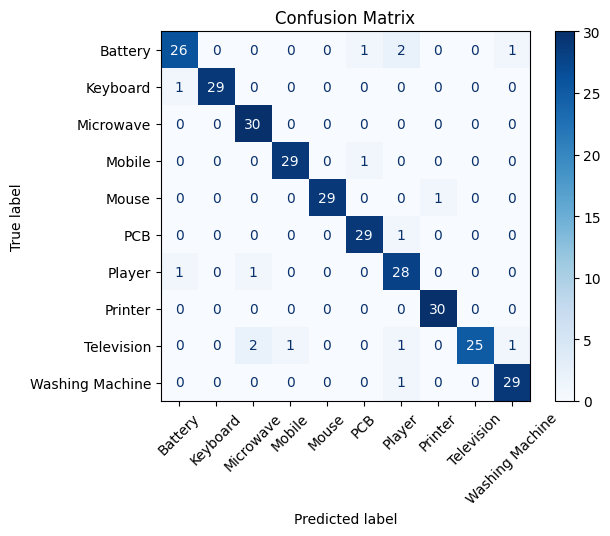

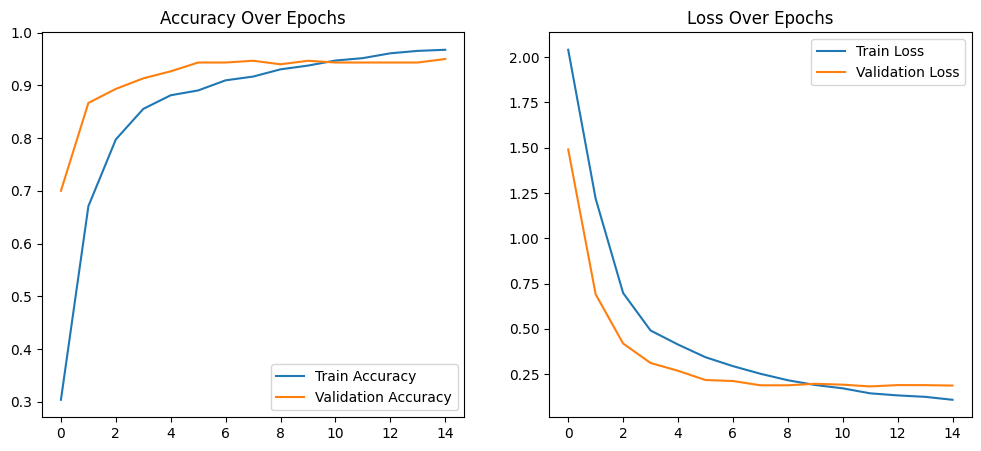

In [10]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_data)
print(f"\nTest accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")
# Get true and predicted labels
y_true = np.concatenate([y.numpy() for _, y in test_data], axis=0)
y_pred = np.argmax(model.predict(test_data), axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot with class names
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

## Model Saving and Gradio Interface

This section saves the trained model to a file. It then defines a Gradio interface for classifying new images. The `classify_image` function preprocesses the input image, makes a prediction using the trained model, and returns the predicted class and confidence.

In [ ]:
# Save model
model.save('efficientnet_ewaste_classifier.keras')

# Gradio interface with error handling
def classify_image(img):
    try:
        # Preprocess image
        img = img.resize((128, 128))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)
        img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

        # Make prediction
        prediction = model.predict(img_array, verbose=0)  # Disable prediction logs
        predicted_class = class_names[np.argmax(prediction)]
        confidence = np.max(prediction)

        return f"Predicted: {predicted_class} (Confidence: {confidence:.2f})"
    except Exception as e:
        return f"Error processing image: {str(e)}"

# Create interface
iface = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil"),
    outputs="text",
    #examples=[["./sample_battery.jpg"], ["./sample_keyboard.jpg"]],  # Added ./ for path clarity
    title="E-Waste Classifier",
    description="Upload an image of e-waste to classify it into one of 10 categories.",
    allow_flagging="never"  # Disable the flag feature for simplicity
)

iface.launch()
